In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.optimize import minimize
from datetime import datetime

In [4]:
# ==========================
# Step 1: Data Collection (Live Data Integration)
# ==========================

def fetch_sp500_tickers():
    """Fetch S&P 500 tickers from Wikipedia."""
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    sp500_table = pd.read_html(url)[0]
    return sp500_table[['Symbol', 'GICS Sector']]

def clean_tickers(tickers):
    """Fix tickers with dot notation for Yahoo Finance."""
    return [t.replace('.', '-') for t in tickers]  # BRK.B → BRK-B

def filter_valid_tickers(tickers, start_date, end_date):
    """Check which tickers have valid data on Yahoo Finance."""
    valid_tickers = []
    for ticker in tickers:
        try:
            data = yf.Ticker(ticker).history(start=start_date, end=end_date)
            if not data.empty:
                valid_tickers.append(ticker)
            else:
                print(f"Skipping {ticker}: No data found.")
        except Exception as e:
            print(f"Skipping {ticker}: {e}")
    return valid_tickers

def fetch_stock_data(tickers, start_date, end_date):
    """Download stock data for valid tickers."""
    data = yf.download(tickers, start=start_date, end=end_date)
    
    # Check if 'Adj Close' exists in the returned data
    if 'Adj Close' in data:
        return data['Adj Close'].dropna(axis=1)  # Remove columns with NaN
    else:
        print("Warning: 'Adj Close' column not found in data. Returning raw data.")
        return data  # Return the whole DataFrame for debugging

# Fetch tickers and clean them
sp500_companies = fetch_sp500_tickers()
tickers = clean_tickers(sp500_companies['Symbol'].tolist())

# Define date range
start_date = "2018-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

# Validate tickers and fetch data
valid_tickers = filter_valid_tickers(tickers, start_date, end_date)
data = fetch_stock_data(valid_tickers, start_date, end_date)

# Display the first few rows
print(data.head())


Could not get exchangeTimezoneName for ticker 'ETR' reason: 'chart'
$ETR: possibly delisted; no timezone found


Skipping ETR: No data found.


$HWM: possibly delisted; no price data found  (1d 2018-01-01 -> 2025-02-09)


Skipping HWM: No data found.


$J: possibly delisted; no price data found  (1d 2018-01-01 -> 2025-02-09)


Skipping J: No data found.


$LEN: possibly delisted; no price data found  (1d 2018-01-01 -> 2025-02-09)


Skipping LEN: No data found.


[*********************100%***********************]  499 of 499 completed


Price           Close                                                   \
Ticker              A       AAPL       ABBV ABNB        ABT       ACGL   
Date                                                                     
2018-01-02  64.180229  40.524334  71.669922  NaN  51.776569  27.988113   
2018-01-03  65.813225  40.517284  72.791466  NaN  51.891048  28.013470   
2018-01-04  65.319519  40.705486  72.376358  NaN  51.802998  28.118069   
2018-01-05  66.363876  41.168926  73.636269  NaN  51.952702  28.007132   
2018-01-08  66.506310  41.016026  72.456467  NaN  51.802998  28.010302   

Price                                                     ...  Volume  \
Ticker             ACN        ADBE        ADI        ADM  ...     WTW   
Date                                                      ...           
2018-01-02  138.659607  177.699997  79.129066  32.879112  ...  817700   
2018-01-03  139.299530  181.039993  80.110710  32.624866  ...  771200   
2018-01-04  140.948990  183.220001  80.023

In [5]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# ==========================
# Step 2: Feature Engineering (Risk, Liquidity & Macro)
# ==========================
# Compute returns and volatility
returns = data.pct_change().dropna()
volatility = returns.rolling(window=20).std().dropna()

def compute_beta(stock_returns, market_returns):
    """Calculate Beta for each stock."""
    if stock_returns.isna().sum() > 0 or market_returns.isna().sum() > 0:
        return np.nan  # Handle missing values
    
    covariance = np.cov(stock_returns.dropna(), market_returns.dropna())[0, 1]
    market_variance = np.var(market_returns.dropna())

    return covariance / market_variance if market_variance > 0 else np.nan

# Approximate S&P 500 market return
sp500_returns = returns.mean(axis=1)

# Compute feature matrix
features = pd.DataFrame({
    "mean_return": returns.mean() * 252,
    "volatility": volatility.mean(),
    "cumulative_return": (data.iloc[-1] / data.iloc[0]) - 1,
    "sharpe_ratio": returns.mean() / (returns.std() + 1e-8),  # Avoid div-by-zero
    "sortino_ratio": returns.mean() / (returns[returns < 0].std() + 1e-8),  # Avoid div-by-zero
    "max_drawdown": (data / data.cummax() - 1).min(),
    "var_95": returns.quantile(0.05),
    "beta": [compute_beta(returns[ticker], sp500_returns) for ticker in returns.columns],
    "liquidity": data.mean(),  # Approximate by average price
})

# Handle Inf and NaNs before scaling
features.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace Inf with NaN
features.dropna(inplace=True)  # Drop rows with NaN values

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert back to DataFrame
features_scaled_df = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)

# Display first few rows
print(features_scaled_df.head())


C:\Users\bhavy\AppData\Local\Temp\ipykernel_6104\3950672875.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


              mean_return  volatility  cumulative_return  sharpe_ratio  \
Price Ticker                                                             
Close A         -0.461323   -0.489201          -0.067621     -0.047252   
      AAPL      -0.488133   -0.499602           1.201693     -0.772085   
      ABBV      -0.457299   -0.487787           0.082551     -0.036497   
      ABT       -0.443102   -0.508513           0.019517      0.721704   
      ACGL      -0.487660   -0.486642           0.340338     -0.767860   

              sortino_ratio  max_drawdown    var_95      beta  liquidity  
Price Ticker                                                              
Close A           -0.229715      0.805469  0.505174 -0.469136  -0.115417  
      AAPL        -0.741817      0.993460  0.484087 -0.464818  -0.115415  
      ABBV        -0.421040      0.700537  0.526798 -0.467043  -0.115417  
      ABT          0.235049      1.200175  0.542720 -0.476886  -0.115418  
      ACGL        -0.737381    

In [6]:
# ==========================
# Step 3: Advanced Clustering (Hierarchical + GMM + DBSCAN)
# ==========================
# Use scaled features for clustering
X_scaled = features_scaled_df.copy()

# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=10, linkage='ward')
X_scaled['hierarchical_cluster'] = hierarchical.fit_predict(features_scaled_df)

# Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=10, random_state=42)
X_scaled['gmm_cluster'] = gmm.fit_predict(features_scaled_df)

# DBSCAN Clustering (Density-based)
dbscan = DBSCAN(eps=1.5, min_samples=5)
X_scaled['dbscan_cluster'] = dbscan.fit_predict(features_scaled_df)

# Save Clustering Data
X_scaled.to_csv("advanced_clustered_data.csv")

# Display first few rows of results
print(X_scaled.head())


              mean_return  volatility  cumulative_return  sharpe_ratio  \
Price Ticker                                                             
Close A         -0.461323   -0.489201          -0.067621     -0.047252   
      AAPL      -0.488133   -0.499602           1.201693     -0.772085   
      ABBV      -0.457299   -0.487787           0.082551     -0.036497   
      ABT       -0.443102   -0.508513           0.019517      0.721704   
      ACGL      -0.487660   -0.486642           0.340338     -0.767860   

              sortino_ratio  max_drawdown    var_95      beta  liquidity  \
Price Ticker                                                               
Close A           -0.229715      0.805469  0.505174 -0.469136  -0.115417   
      AAPL        -0.741817      0.993460  0.484087 -0.464818  -0.115415   
      ABBV        -0.421040      0.700537  0.526798 -0.467043  -0.115417   
      ABT          0.235049      1.200175  0.542720 -0.476886  -0.115418   
      ACGL        -0.7373

In [7]:
# import numpy as np
# from scipy.optimize import minimize


# ==========================
# Step 4: Portfolio Optimization (Mean-Variance)
# ==========================

def portfolio_performance(weights, returns):
    """Calculate portfolio return, volatility, and Sharpe ratio."""
    portfolio_return = np.sum(weights * returns.mean()) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    
    # Avoid division by zero
    sharpe_ratio = portfolio_return / portfolio_volatility if portfolio_volatility > 0 else 0
    return portfolio_return, portfolio_volatility, sharpe_ratio



In [8]:
def minimize_sharpe(weights, returns):
    """Objective function to minimize negative Sharpe ratio."""
    return -portfolio_performance(weights, returns)[2]  # Minimize negative Sharpe



In [9]:
def optimize_portfolio(returns):
    """Optimize portfolio allocation using Mean-Variance optimization."""
    returns = returns.dropna(axis=1)  # Ensure valid returns data

    num_assets = len(returns.columns)
    initial_weights = np.ones(num_assets) / num_assets
    bounds = [(0, 1) for _ in range(num_assets)]  # Weight constraints (0 to 1)
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Sum of weights must be 1

    optimized = minimize(minimize_sharpe, initial_weights, args=(returns,), 
                         method='SLSQP', bounds=bounds, constraints=constraints)
    
    return optimized.x if optimized.success else None  # Return weights if optimization is successful



In [10]:
# Select the cluster (Change as needed)
selected_cluster = 0

# Get all stocks in the selected cluster
selected_stocks = X_scaled[X_scaled['hierarchical_cluster'] == selected_cluster].index
cluster_returns = returns[selected_stocks]  # Get returns for these stocks

# Compute Sharpe Ratio for ranking (Higher is better)
sharpe_ratios = (cluster_returns.mean() * 252) / (cluster_returns.std() + 1e-8)  # Avoid div-by-zero

# Select Top N Stocks (Changeable Parameter for Scalability)
top_n = 100  # Adjust this to change the number of optimized stocks
top_stocks = sharpe_ratios.nlargest(top_n).index  # Get top N stocks

# Use only the top stocks for portfolio optimization
filtered_returns = cluster_returns[top_stocks]


In [12]:
print(f"Number of stocks in Cluster {selected_cluster}: {len(selected_stocks)}")
print(f"Number of stocks with valid return data: {cluster_returns.shape[1]}")
print(len(filtered_returns))

Number of stocks in Cluster 0: 694
Number of stocks with valid return data: 694
148


In [13]:
# Optimize portfolio using only the top N selected stocks
optimized_weights = optimize_portfolio(filtered_returns)


In [14]:
# Display optimized portfolio weights for the selected top N stocks
portfolio_allocation = pd.Series(optimized_weights, index=filtered_returns.columns)
print("Optimized Portfolio Allocation:")
print(portfolio_allocation)


Optimized Portfolio Allocation:
Price  Ticker
High   FI        0.000000e+00
Low    LYV       0.000000e+00
High   NI        3.090954e-02
       WMT       1.259779e-02
Low    WMT       9.923923e-14
                     ...     
Open   CPAY      8.832572e-13
Low    TMUS      2.211718e-12
Close  TRGP      5.035333e-13
Low    GL        0.000000e+00
Open   GL        1.068220e-12
Length: 100, dtype: float64


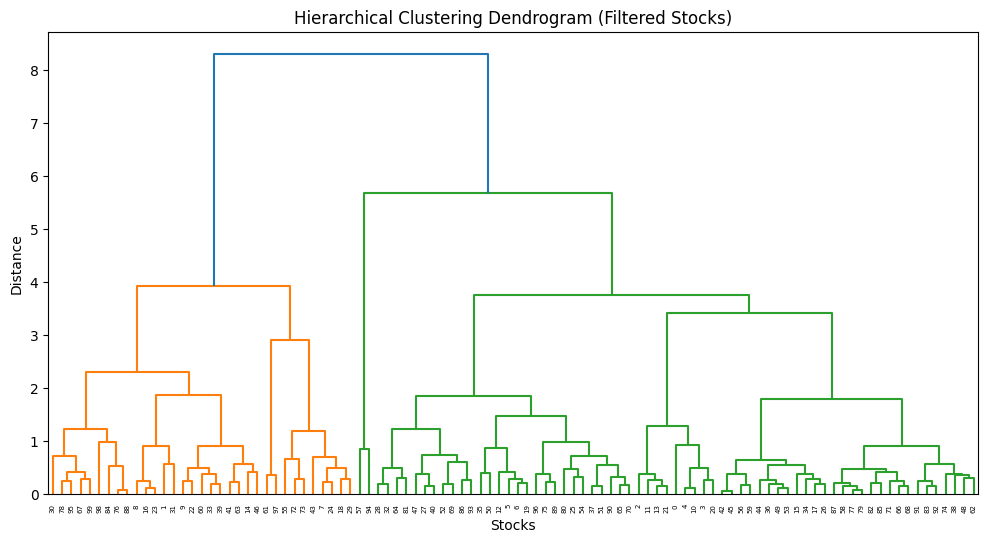

In [17]:
# Ensure clustering results exist
if 'hierarchical_cluster' not in X_scaled.columns:
    raise ValueError("Clustering results not found. Run Step 3 before visualization.")

# ==========================
# Dendrogram (Hierarchical Clustering for Filtered Stocks)
# ==========================

# Limit features_scaled_df to only filtered stocks
filtered_features_scaled_df = features_scaled_df.loc[filtered_returns.columns]

plt.figure(figsize=(12, 6))
dendrogram(linkage(filtered_features_scaled_df, method='ward'))
plt.title("Hierarchical Clustering Dendrogram (Filtered Stocks)")
plt.xlabel("Stocks")
plt.ylabel("Distance")
plt.show()


In [25]:
# ==========================
# t-SNE Visualization (Only for Selected Portfolio Stocks)
# ==========================
from sklearn.manifold import TSNE
import plotly.express as px

# ==========================
# Step 1: Ensure `filtered_returns` Uses Stock Names Instead of Dates
# ==========================
if isinstance(filtered_returns.index[0], pd.Timestamp):
    print("⚠ Warning: `filtered_returns.index` contains dates. Using `.columns` instead.")
    filtered_stocks = list(filtered_returns.columns)  # Use stock tickers
else:
    filtered_stocks = list(filtered_returns.index)  # Use index if it's stock names

# Debugging: Print stock counts before filtering
print(f"✅ Stocks in filtered_returns: {len(filtered_stocks)}")
print(f"✅ Stocks in X_scaled before filtering: {X_scaled.shape[0]}")

# ==========================
# Step 2: Filter `X_scaled` to Include Only Selected Portfolio Stocks
# ==========================
X_scaled_filtered = X_scaled.loc[filtered_stocks].reset_index()

# Debugging: Print stock count after filtering
print(f"✅ Stocks in X_scaled after filtering: {X_scaled_filtered.shape[0]}")

# ==========================
# Step 3: Ensure Only Numeric Data is Passed to t-SNE
# ==========================
# Print column data types for debugging
print("✅ Column types before t-SNE:")
print(X_scaled_filtered.dtypes)

# Drop non-numeric columns (e.g., Stock Names, Categorical Data)
X_scaled_numeric = X_scaled_filtered.select_dtypes(include=[np.number])

# Debugging: Print remaining numeric columns
print(f"✅ Columns used for t-SNE: {list(X_scaled_numeric.columns)}")

# ==========================
# Step 4: Apply t-SNE (Only If Enough Stocks Exist)
# ==========================
n_samples = X_scaled_numeric.shape[0]

if n_samples > 2:  # t-SNE requires at least 2 samples
    perplexity_value = min(30, max(2, n_samples - 1))  # Ensure valid perplexity

    tsne = TSNE(n_components=2, perplexity=perplexity_value, learning_rate='auto', random_state=42)
    tsne_results = tsne.fit_transform(X_scaled_numeric)  # Use only numeric columns

    # Add t-SNE results to the DataFrame
    X_scaled_filtered['tsne_1'] = tsne_results[:, 0]
    X_scaled_filtered['tsne_2'] = tsne_results[:, 1]

    # ==========================
    # Step 5: Interactive Scatter Plot (Filtered Stocks Only)
    # ==========================
    fig = px.scatter(X_scaled_filtered, x='tsne_1', y='tsne_2', 
                     color=X_scaled_filtered['hierarchical_cluster'].astype(str) if 'hierarchical_cluster' in X_scaled_filtered.columns else None, 
                     title="t-SNE Visualization of Selected Portfolio Stocks", 
                     hover_name="Ticker")  # Fix: Replace "Stock" with "Ticker"

    # Show the plot
    fig.show(renderer="browser")

else:
    print(f"⚠ Not enough samples for t-SNE. Only {n_samples} stocks selected.")


⚠ Warning: `filtered_returns.index` contains dates. Using `.columns` instead.
✅ Stocks in filtered_returns: 100
✅ Stocks in X_scaled before filtering: 2399
✅ Stocks in X_scaled after filtering: 100
✅ Column types before t-SNE:
Price                 object
Ticker                object
mean_return          float64
volatility           float64
cumulative_return    float64
sharpe_ratio         float64
sortino_ratio        float64
max_drawdown         float64
var_95               float64
beta                 float64
liquidity            float64
dtype: object
✅ Columns used for t-SNE: ['mean_return', 'volatility', 'cumulative_return', 'sharpe_ratio', 'sortino_ratio', 'max_drawdown', 'var_95', 'beta', 'liquidity']


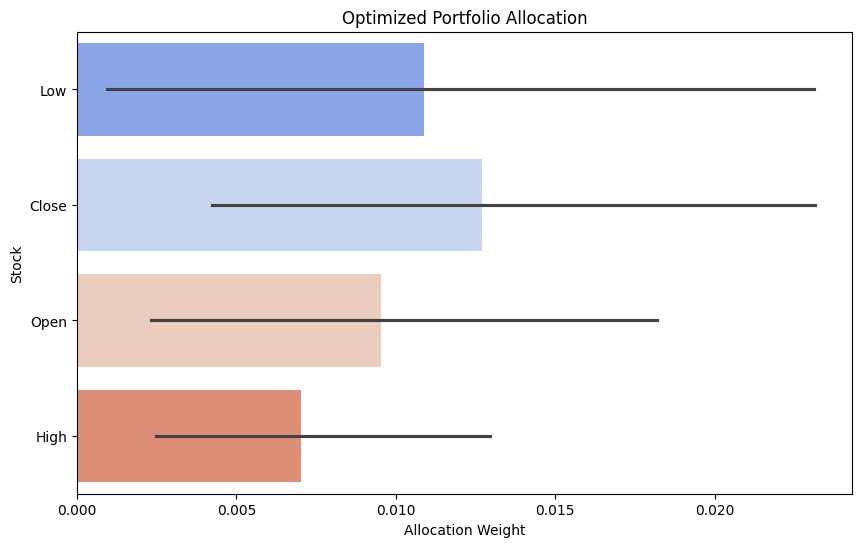

In [30]:
# ==========================
# Portfolio Allocation Visualization
# ==========================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure `optimized_weights` exist
if optimized_weights is not None:
    # Convert MultiIndex to a flat index (if needed)
    stock_names = [col[0] if isinstance(col, tuple) else col for col in filtered_returns.columns]  # Updated

    # Create allocation DataFrame
    allocation_df = pd.DataFrame({'Stock': stock_names, 'Weight': optimized_weights})
    allocation_df = allocation_df.sort_values(by='Weight', ascending=False)

    # Plot the allocation
    plt.figure(figsize=(10, 6))
    # sns.barplot(x='Weight', y='Stock', data=allocation_df, palette="coolwarm")
    sns.barplot(x='Weight', y='Stock', data=allocation_df, hue='Stock', palette="coolwarm", legend=False)

    plt.title("Optimized Portfolio Allocation")
    plt.xlabel("Allocation Weight")
    plt.ylabel("Stock")
    plt.show()

else:
    print("Portfolio optimization failed. No visualization available.")


In [28]:
# ==========================
# Save Stock Name, Price & Weight to CSV
# ==========================
import pandas as pd

# Ensure `optimized_weights` exist before proceeding
if optimized_weights is not None:
    # Convert MultiIndex to a flat index (if needed)
    stock_names = [col[0] if isinstance(col, tuple) else col for col in filtered_returns.columns]  

    # Create DataFrame with stock allocation
    allocation_df = pd.DataFrame({
        'Stock': stock_names,
        'Weight': optimized_weights
    })

    # Merge with stock prices from X_scaled_filtered
    stock_prices = X_scaled_filtered[['Ticker', 'Price']].set_index("Ticker")  # Ensure "Ticker" and "Price" exist
    final_df = allocation_df.merge(stock_prices, left_on="Stock", right_index=True, how="left")

    # Save to CSV
    csv_filename = "optimized_portfolio_simple.csv"
    final_df.to_csv(csv_filename, index=False)

    print(f"✅ Stock Name, Price & Weight saved to {csv_filename}")

else:
    print("❌ Portfolio optimization failed. No CSV file was created.")


✅ Stock Name, Price & Weight saved to optimized_portfolio_simple.csv


In [29]:
# ==========================
# Print Filtered Stock Names
# ==========================

# Ensure that `filtered_returns` contains the selected stocks
filtered_stocks = list(filtered_returns.columns)  # Extract stock names

# Print the list of filtered stocks
print("✅ Filtered Stocks for Optimization:")
for stock in filtered_stocks:
    print(stock)


✅ Filtered Stocks for Optimization:
('High', 'FI')
('Low', 'LYV')
('High', 'NI')
('High', 'WMT')
('Low', 'WMT')
('Low', 'FI')
('Open', 'FI')
('Low', 'UAL')
('High', 'LYV')
('Low', 'BK')
('Close', 'WMT')
('High', 'AEE')
('Low', 'ADP')
('Low', 'AEE')
('Low', 'FFIV')
('Low', 'NI')
('Close', 'LYV')
('Low', 'GILD')
('Close', 'UAL')
('Close', 'FI')
('Open', 'WMT')
('High', 'CME')
('High', 'BK')
('Open', 'LYV')
('High', 'UAL')
('High', 'NDAQ')
('Open', 'GILD')
('High', 'BSX')
('Low', 'CBRE')
('Low', 'TPR')
('Close', 'GL')
('Low', 'WELL')
('Open', 'CBRE')
('Open', 'BK')
('Open', 'AEE')
('High', 'ADP')
('Close', 'AEE')
('Close', 'ADP')
('Low', 'PM')
('Close', 'BK')
('Close', 'BSX')
('Close', 'FFIV')
('Close', 'NI')
('Open', 'UAL')
('Low', 'WEC')
('Open', 'NI')
('High', 'WELL')
('High', 'GDDY')
('Low', 'EVRG')
('High', 'GILD')
('High', 'CBRE')
('Open', 'ADP')
('Low', 'GDDY')
('High', 'WEC')
('Open', 'NDAQ')
('Close', 'TPR')
('Close', 'GILD')
('Low', 'K')
('Low', 'CSCO')
('Close', 'WEC')
('High',